<a href="https://colab.research.google.com/github/aguilarafa2010/Aplicacao_Multimidia/blob/main/Classificacao_Doenca_Pulmonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bibliotecas

# Load the images from the dataset (1000 images, 10 different classes)
from imutils import paths
from google.colab.patches import cv2_imshow
import os, cv2

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Model Fine Tuning
import numpy as np
import pandas as pd
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import keras.utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import numpy as np
import itertools

from keras.preprocessing.image import ImageDataGenerator

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import MaxPooling2D, ZeroPadding2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
import keras.optimizers
from keras import regularizers
import keras
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import matplotlib.style as sty
import seaborn as sns

plt.rcParams["figure.figsize"] = [20,5]
sns.set_style("ticks")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## IMPORTAÇÃO DOS DADOS

In [ ]:
# general path
path="/content/drive/MyDrive/Trabalho/Pós Graduação/Aplicação Multimídia/"
shared = "Raw Dataset (RYDLS-20)/"

In [ ]:
# List of paths 
file_list=[]
file_list.append(os.listdir(path + shared + "COVID-19"))
file_list.append(os.listdir(path + shared + "MERS"))
file_list.append(os.listdir(path + shared + "Normal"))
file_list.append(os.listdir(path + shared + "Pneumocystis"))
file_list.append(os.listdir(path + shared + "SARS"))
file_list.append(os.listdir(path + shared + "Streptococcus"))
file_list.append(os.listdir(path + shared + "Varicella"))


# list of classes
class_names = ['COVID-19', 'MERS', 'Normal', 'Pneumocystis', 'SARS', 'Streptococcus', 'Varicella'] 

X = []
y = []

# Feature extraction
for classes_files, classe in zip (file_list, range(7)):
    for i in range(len(classes_files)):
      try:
        name = str(class_names[classe]) + str('/') + str(classes_files[i]) 
        print(name)
        imagem = cv2.imread(f'{path}{shared}{name}', cv2.IMREAD_UNCHANGED)
  
        print('Original Dimensions : ',imagem.shape)
        imagem = cv2.resize(imagem,(224,224))  #### <=====

        print(imagem.shape)
        altura, largura, _ = imagem.shape
        img = np.asarray(imagem)
        if imagem.shape == (224, 224, 3):
          y.append(classe)      
          X.append(img)

      except Exception as e:
        print(str(e))

#Saving the extracted features (deep) in a csv file
np.save('X', X)

# Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)

COVID-19/1082.jpg
Original Dimensions :  (3104, 3272, 3)
(224, 224, 3)
COVID-19/1066.jpg
Original Dimensions :  (1156, 1157, 3)
(224, 224, 3)
COVID-19/1097.jpg
Original Dimensions :  (3071, 2873, 3)
(224, 224, 3)
COVID-19/1072.jpg
Original Dimensions :  (411, 477, 3)
(224, 224, 3)
COVID-19/1073.jpg
Original Dimensions :  (478, 463, 3)
(224, 224, 3)
COVID-19/1067.jpg
Original Dimensions :  (1130, 1577, 3)
(224, 224, 3)
COVID-19/1068.jpg
Original Dimensions :  (976, 911, 3)
(224, 224, 3)
COVID-19/1069.jpg
Original Dimensions :  (974, 929, 3)
(224, 224, 3)
COVID-19/1070.jpg
Original Dimensions :  (956, 905, 3)
(224, 224, 3)
COVID-19/1071.jpg
Original Dimensions :  (980, 919, 3)
(224, 224, 3)
COVID-19/1078.jpg
Original Dimensions :  (1523, 1311, 3)
(224, 224, 3)
COVID-19/1120.jpg
Original Dimensions :  (2108, 1936, 4)
(224, 224, 4)
COVID-19/1080.jpg
Original Dimensions :  (1370, 1545, 3)
(224, 224, 3)
COVID-19/1083.jpg
Original Dimensions :  (1354, 1449, 3)
(224, 224, 3)
COVID-19/1081.jpg


In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
#Função para realizar e plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
# Load the images and the corresponding labels
y = pd.read_csv(f'{path}y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)
print(y.shape)

X=np.load(f'{path}X.npy')
print(X.shape)

(1125,)
(1125, 224, 224, 3)


#2) Plote das classes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8dd61f3d0>]],
      dtype=object)

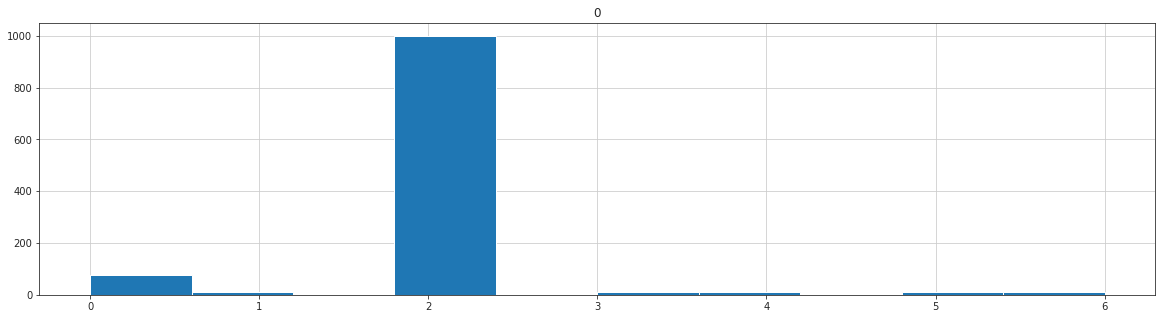

In [ ]:
grupos = pd.DataFrame(y)
grupos.hist()

In [ ]:
# Holdout -> dividindo a base em treinamento (70%) e teste (30%), estratificada
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# prepare pixel and Data normalization
X_train, X_test = prep_pixels(X_train, X_test)

# Preparing the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Load VGG16 without the top FC Layers.
from keras.layers import Lambda, Input
from tensorflow.image import resize

vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_conv.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# Fine Tunning VGG16 
# Create 'model' from vgg_conv adding dense layers and reducing the number of classes to 10
def define_model():
  
  model = Sequential()
  model.add(Input((32,32,3)))
  model.add(Lambda(lambda image: resize(image, (224, 224))))
  model.add(vgg_conv)
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))

  return model

In [ ]:
model = define_model()

# Freeze the layers except the last 4 layers
for layer in model.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

<keras.layers.core.Lambda object at 0x7fd8d03ed810> False
<keras.engine.functional.Functional object at 0x7fd8d0397c50> False
<keras.layers.core.Flatten object at 0x7fd8d03d4050> True
<keras.layers.core.Dense object at 0x7fd8d016dad0> True
<keras.layers.core.Dropout object at 0x7fd8d0166f10> True
<keras.layers.core.Dense object at 0x7fd8d03d2c90> True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
________________________________

In [ ]:
#Configurações Arbritarias escolhidas para treinamento
batch_size = 128
epochs = 20

In [ ]:
# Traning the model
print(X_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, y_train, 
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          callbacks = [es],
          validation_split = 0.2)

(787, 224, 224, 3)
Epoch 1/20
5/5 [==============================] - 102s 11s/step - loss: 5.1996 - accuracy: 0.7440 - val_loss: 7.6190 - val_accuracy: 0.8608


Confusion matrix, without normalization
[[  0   0  23   0   0   0   0]
 [  0   0   3   0   0   0   0]
 [  0   0 300   0   0   0   0]
 [  0   0   3   0   0   0   0]
 [  0   0   3   0   0   0   0]
 [  0   0   3   0   0   0   0]
 [  0   0   3   0   0   0   0]]


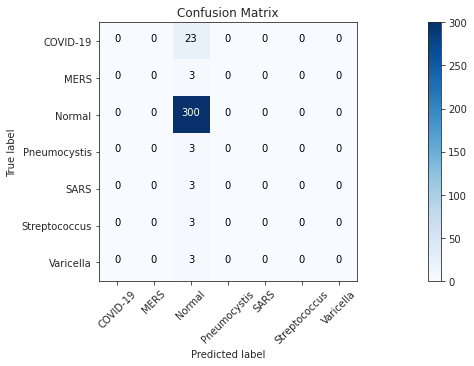

In [ ]:
y_predict = np.argmax(model.predict(X_test), axis=-1)

cm = confusion_matrix(np.argmax(y_test,axis=1),y_predict)
cm_plot_labels = ['COVID-19', 'MERS', 'Normal', 'Pneumocystis', 'SARS', 'Streptococcus', 'Varicella'] 
plot_confusion_matrix(cm,cm_plot_labels,title ='Confusion Matrix')

In [ ]:
# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Final Accuracy: > %.3f' % (acc * 100.0))

Final Accuracy: > 88.757


In [ ]:
print('Recal')
recall_classe_a = recall_score(np.argmax(y_test,axis=1), y_predict, average=None)
print(recall_classe_a)

print('Precision')
precision_classe_a = precision_score(np.argmax(y_test,axis=1), y_predict, average=None)
print(precision_classe_a)


print('F1 Score')
score_classe_a = f1_score(np.argmax(y_test,axis=1), y_predict, average=None)
print(score_classe_a)

Recal
[0. 0. 1. 0. 0. 0. 0.]
Precision
[0.         0.         0.88757396 0.         0.         0.
 0.        ]
F1 Score
[0.         0.         0.94043887 0.         0.         0.
 0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Data Augmentation

In [ ]:
# Data Augmentation

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [ ]:
# Apply the generator
datagen.fit(X_train)

In [ ]:
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=128)

In [ ]:
# fit model
es2 = EarlyStopping(monitor='accuracy', mode='min', verbose=1)
steps = int(X_train.shape[0] / 64)
history = model.fit_generator(it_train, 
                              epochs=20,
                              verbose=1,
                              callbacks = [es2])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 4.9250 - accuracy: 0.8234


In [ ]:
# Saving the fine tuned model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

# list of classes
class_names=['COVID-19', 'MERS', 'Normal', 'Pneumocystis', 'SARS', 'Streptococcus', 'Varicella'] 

# Saving weights
model.save_weights('My_model_weights.h5')

# Save the model architecture
with open('My_model_architecture.json', 'w') as f:
    f.write(model.to_json())

# Loading the model
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('My_model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

In [ ]:
# Load weights into the new model
model.load_weights('My_model_weights.h5')

# Applying the model
# load an image from file
image = load_img(path + shared + "MERS/1020.png", target_size=(224, 224))

# convert the image pixels to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = model.predict(image)
print(yhat)

# retrieve the most likely result, e.g. highest probability
label = np.argmax(yhat)

# print the classification
print(class_names[label])

[[0. 0. 1. 0. 0. 0. 0.]]
Normal
